In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mass_spec_utils

In [3]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/'

osp = MAC

Running standards. First of all, we need to be able to read the new mzML file or csv file. Let's try first with the mzML file.

In [4]:
new_mzml_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/Zika/Positive/Standards/Std1_1_23Oct18.mzML"
old_mzml_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/Zika/Positive/Standards/Std1_2_23Oct18.mzML"

Next, we need to extract the standards from inside the new_mzml file.
In order to do this, I quess I will use the method Simon suggested, i.e. choose m/z with highest intensities
(search for method in his code). 

In [5]:
from mass_spec_utils.data_import.mzml import MZMLFile

In [6]:
new_mzml = MZMLFile(new_mzml_file)
old_mzml = MZMLFile(old_mzml_file)

Loaded 1185 scans
Loaded 1192 scans


Next, extract the standards from inside the old_mzml file in the same way as above.

In [7]:
standards_list_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/standards_list.csv"
standards = pd.read_csv(standards_list_file)

In [8]:
sys.path.append("../")
import metab_utils

In [11]:
standards_list_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/standards_list.csv"
standards = pd.read_csv(standards_list_file)
standards_list = metab_utils.create_std_dict_by_mz(standards, polarity = '+')
with open(osp+'Metabolomics_datasets/standards_list.dict', 'wb') as handle:
    pickle.dump(standards_list, handle)

In [99]:
new_mzml_rts = []
old_mzml_rts = []
ppm = 0.1
for mz in standards_list:
    new_rt = new_mzml.get_max_intensity(mz_min = mz - ppm , mz_max = mz +ppm)[1]
    new_mzml_rts.append(new_rt/60)
    old_rt = old_mzml.get_max_intensity(mz_min = mz - ppm , mz_max = mz +ppm)[1]
    old_mzml_rts.append(old_rt/60)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [138]:
from metab_utils import return_data_with_no_outliers
new_mzml_rts_mod, old_mzml_rts_mod = return_data_with_no_outliers(new_mzml_rts, old_mzml_rts, np.subtract(new_mzml_rts,old_mzml_rts), 1)

print("Choosing the optimal kernel...")
from metab_utils import try_gp_regressions
model, kernel, results = try_gp_regressions(np.array(new_mzml_rts_mod), np.array(old_mzml_rts_mod)-np.array(new_mzml_rts_mod))

Choosing the optimal kernel...
Cross-Predicted Accuracy for RBF : -0.02374298407141029
Mean absolute error for RBF : 0.023185903893535344
Mean squared error for RBF : 0.0008304628192384405
Cross-Predicted Accuracy for MLP : -0.023731728941047914
Mean absolute error for MLP : 0.023185817730390537
Mean squared error for MLP : 0.0008304536890490891


 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Cross-Predicted Accuracy for MLP+RBF : 0.0006497385495928265
Mean absolute error for MLP+RBF : 0.023448190464706066
Mean squared error for MLP+RBF : 0.00081067538282918
Cross-Predicted Accuracy for MLP*RBF : 0.19930708724168245
Mean absolute error for MLP*RBF : 0.022213923876467787
Mean squared error for MLP*RBF : 0.0006495240543959892
Cross-Predicted Accuracy for Cosine*RBF : 0.17520470570321045
Mean absolute error for Cosine*RBF : 0.02241888562213524
Mean squared error for Cosine*RBF : 0.000669075965407087
Cross-Predicted Accuracy for Cosine+RBF : -0.023742995522954224
Mean absolute error for Cosine+RBF : 0.023185903221073945
Mean squared error for Cosine+RBF : 0.000830462828527961
Final kernel: MLP*RBF


  mul.                 |                  value  |  constraints  |  priors
  mlp.variance         |    0.00859869660799844  |      +ve      |        
  mlp.weight_variance  |    0.08449223528336045  |      +ve      |        
  mlp.bias_variance    |  3.842095366246017e-06  |      +ve      |        
  rbf.variance         |     0.2163663945107785  |      +ve      |        
  rbf.lengthscale      |      4.817996008776943  |      +ve      |        
Optimization restart 1/10, f = -95.4689809652259
Optimization restart 2/10, f = -95.4689788678081
Optimization restart 3/10, f = -95.46898102327347
Optimization restart 4/10, f = -95.46898021160862
Optimization restart 5/10, f = -95.46898099331186
Optimization restart 6/10, f = -95.46897850025124
Optimization restart 7/10, f = -95.46898114570247
Optimization restart 8/10, f = -95.46897832427607
Optimization restart 9/10, f = -95.46898122079565
Optimization restart 10/10, f = -95.46898130706933


{'dataplot': [<matplotlib.collections.PathCollection at 0x115345700>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x115345ee0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x11d4f38e0>]}

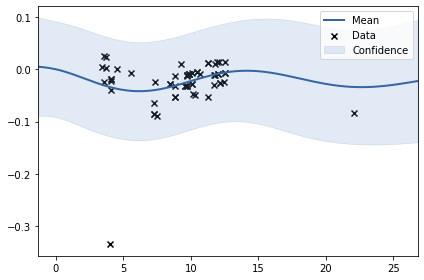

In [122]:
model.optimize_restarts(10)
print(model.parameters[0])
model.plot()

Create method encapsulating the code in this notebook.

In [30]:
def get_gp_for_new_file(new_mzml_file, old_mzml_file, standards_list, mz_ppm = 0.1, zscore = 1):
    from mass_spec_utils.data_import.mzml import MZMLFile
    print("Creating MZMLFile objects...")
    new_mzml = MZMLFile(new_mzml_file)
    old_mzml = MZMLFile(old_mzml_file)
    
    new_mzml_rts = []
    old_mzml_rts = []
   
    for mz in standards_list:
        new_rt = new_mzml.get_max_intensity(mz_min = mz - mz_ppm , mz_max = mz + mz_ppm)[1]
        new_mzml_rts.append(new_rt/60)
        old_rt = old_mzml.get_max_intensity(mz_min = mz - mz_ppm , mz_max = mz + mz_ppm)[1]
        old_mzml_rts.append(old_rt/60)
        
    from metab_utils import return_data_with_no_outliers
    new_mzml_rts_mod, old_mzml_rts_mod = return_data_with_no_outliers(new_mzml_rts, old_mzml_rts, np.subtract(new_mzml_rts,old_mzml_rts), zscore)
    
    print("Choosing the optimal kernel")
    from metab_utils import try_gp_regressions
    model, kernel, results = try_gp_regressions(np.array(new_mzml_rts_mod), np.array(old_mzml_rts_mod)-np.array(new_mzml_rts_mod))
    
    model.optimize_restarts(10)
    print("Kernel hyperparameters:",model.parameters[0])
    model.plot()

Creating MZMLFile objects...
Loaded 1185 scans
Loaded 1192 scans
Choosing the optimal kernel
Cross-Predicted Accuracy for RBF : -0.02374298407141029
Mean absolute error for RBF : 0.023185903893535344
Mean squared error for RBF : 0.0008304628192384405
Cross-Predicted Accuracy for MLP : -0.023731728941047914
Mean absolute error for MLP : 0.023185817730390537
Mean squared error for MLP : 0.0008304536890490891


 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Cross-Predicted Accuracy for MLP+RBF : 0.0006497385495928265
Mean absolute error for MLP+RBF : 0.023448190464706066
Mean squared error for MLP+RBF : 0.00081067538282918
Cross-Predicted Accuracy for MLP*RBF : 0.19930708724168245
Mean absolute error for MLP*RBF : 0.022213923876467787
Mean squared error for MLP*RBF : 0.0006495240543959892
Cross-Predicted Accuracy for Cosine*RBF : 0.17520470570321045
Mean absolute error for Cosine*RBF : 0.02241888562213524
Mean squared error for Cosine*RBF : 0.000669075965407087
Cross-Predicted Accuracy for Cosine+RBF : -0.023742995522954224
Mean absolute error for Cosine+RBF : 0.023185903221073945
Mean squared error for Cosine+RBF : 0.000830462828527961
Final kernel: MLP*RBF
Optimization restart 1/10, f = -95.4689809652259
Optimization restart 2/10, f = -95.46898110449027
Optimization restart 3/10, f = -95.46898136122059
Optimization restart 4/10, f = -95.46898113473549
Optimization restart 5/10, f = -95.46897577041662
Optimization restart 6/10, f = -95.4

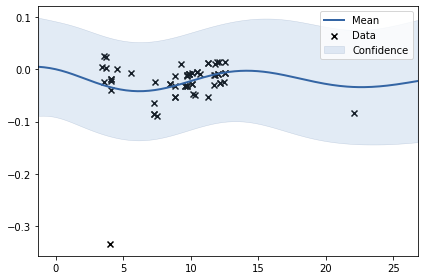

In [142]:
get_gp_for_new_file(new_mzml_file, old_mzml_file, standards_list)

Check fragmentation file

In [1]:
frag_mzml_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/Zika/FRAG/FRAG_POS.mzML"

In [2]:
from mass_spec_utils.data_import.mzml import MZMLFile
frag_mzml = MZMLFile(frag_mzml_file)

2021-01-18 10:15:27.320 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 9657 scans


Create dictionary with the filtered peaks found in the meta-dataset.

In [7]:
annotated_data = pd.read_csv(osp+'pymz/mzmine/peak_picked_files/annotated_data.csv', sep = ',', index_col = 0)

sys.path.append("/Users/anamaria/git/molnet/code/")
import mnet
with open(os.path.join(osp,'pymz/mzmine/HMDBannotated_data.csv'), 'rb') as file:
    annodat = pickle.load(file)   
    
annotated_data['spectra'] = None
for i in annodat.index:
    if i in annotated_data.index:
        annotated_data.at[i, 'spectra'] = annodat.loc[i]['spectra']

In [8]:
filtered_peaks = {}
for _,row in annotated_data.iterrows():
    mz = row['row m/z']
    rt = row['row retention time']
    pval = row['adj p-val']
    cid = row['custom_id']
    mmcn = row['compound_names']
    spec = row['spectra']
    filtered_peaks[mz] = (mmcn, rt*60, '+', None, pval, cid, spec)
    

In [11]:
len(filtered_peaks)

604

In [4]:
def get_tolerance(x, ppm):
    """
    Returns tolerance based on ppm value.
    """
    tolerance = x*ppm/1000000
    return tolerance

In [15]:
ppm_mz = 3
ppm_rt = 3.0
count_rt = 0
count_spec = 0
max_int_peaks = []
specs_names = []
for mz in filtered_peaks:
    
    filtered_peaks_rt =  filtered_peaks[mz][1]
    filtered_peaks_spec = filtered_peaks[mz][6]
    ppm = get_tolerance(mz, ppm_mz)
    try:
        max_int_peaks.append(frag_mzml.get_max_intensity(mz_min = mz - ppm , mz_max = mz +ppm, rt_min_seconds = filtered_peaks_rt - ppm_rt,
                                              rt_max_seconds = filtered_peaks_rt + ppm_rt))
    except AttributeError:
        print("no peak found",mz)
    
    if filtered_peaks_spec != None:
        count_spec +=1
        for spec in filtered_peaks_spec.keys():
            specs_names.append(spec)

no peak found 785.6511273451255
no peak found 788.6709195650543
no peak found 103.06953181642471


There are 2046 peaks in total.

In [5]:
frag_picked_peaks = '/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/pymz/mzmine/210120/mzmine_frag/zik/gnps2_quant.csv'

In [6]:
frag_picked_peaks = pd.read_csv(frag_picked_peaks)

In [7]:
pooled_picked_peaks = pd.read_csv('/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/picked_peaks/zik_pooled/pooled_10.mzXML_chromatograms3ppm_deconvoluted.csv')

In [8]:
filtered_peaks = pd.read_csv('/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/positive_mode/limma_independent_toptable_features_boxes_individual_logfc_annotated.csv')

In [23]:
pooled_picked_peaks

,row ID,row m/z,row retention time,pooled_10.mzXML Peak m/z,pooled_10.mzXML Peak RT start,pooled_10.mzXML Peak RT end,pooled_10.mzXML Peak area,pooled_10.mzXML Peak m/z min,pooled_10.mzXML Peak m/z max,Unnamed: 9
0,1,70.065147,10.625950,70.065147,10.447100,10.861467,3.115046e+07,70.065056,70.065186,NaN
1,2,70.065048,18.822500,70.065048,18.553667,19.252000,2.346572e+06,70.064941,70.065132,NaN
2,3,70.065147,16.461567,70.065147,16.260917,16.610717,7.592908e+05,70.065041,70.065201,NaN
3,4,71.068459,10.601083,71.068459,10.559000,10.646950,7.822952e+05,71.068451,71.068565,NaN
4,5,72.055481,11.789950,72.055481,11.639800,11.873850,1.320344e+06,72.055428,72.055527,NaN
...,...,...,...,...,...,...,...,...,...,...
3238,3239,904.828674,5.792367,904.828674,5.374267,6.186183,1.334651e+06,904.826294,904.830566,NaN
3239,3240,904.827881,4.738417,904.827881,4.428783,4.825450,4.850573e+05,904.825989,904.829895,NaN
3240,3241,905.593933,2.987767,905.593933,2.900300,3.091833,4.652751e+06,905.591675,905.594543,NaN
3241,3242,906.603210,3.008517,906.603210,2.900300,3.050500,2.387850e+06,906.601440,906.603455,NaN


In [12]:
filtered_peaks

,Unnamed: 0,custom_id,row m/z,row retention time,adj-p,t-val,logFC,mal_logfc,vl_logfc,zik_logfc,common,std_annot,mm_annot,hmdb_ms2_annot,mz_min,mz_max,rt_min,rt_max
0,0,604,146.117582,10.726534,0.763760,0.471112,0.055667,-0.168325,1.284911,-0.039924,vl,4-trimethylammoniobutanoate,['3-dehydroxycarnitine'],NaN,146.117493,146.117676,10.497897,11.005606
1,1,412,132.065596,11.575203,0.698407,0.614450,0.120474,0.136189,-2.804799,2.350000,vl,5-aminolevulinate,['l-glutamate 5-semialdehyde; l-glutamate gamm...,Creatine,132.065491,132.065720,11.437827,11.734196
2,2,366,130.049957,9.235738,0.000173,-4.641824,-0.649142,-0.683360,-0.743241,-0.445621,down,5-oxoproline,['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carbo...,Pipecolic acid,130.049561,130.050156,9.025411,9.429342
3,3,615,147.076406,10.106348,0.027475,2.737149,3.225662,-2.736787,12.625208,6.909235,mal,ala-gly,['l-glutamine$3-ureidoisobutyrate$d-glutamine;...,NaN,147.076218,147.076538,10.022898,10.216737
4,4,241,118.086226,10.406101,0.902503,-0.189197,-0.017892,0.054432,-1.060083,-0.217337,mal,betaine,['6-amino-2-oxohexanoate; 2-oxo-6-aminocaproat...,NaN,118.086121,118.086288,10.043342,10.814568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,620,748,156.138400,4.388823,0.907824,-0.177205,-0.323015,-0.032081,-0.064352,2.919773,zik,NaN,NaN,NaN,156.138260,156.138580,4.236312,4.554936
621,621,2864,732.608222,3.341070,0.934623,-0.116698,-0.291068,-0.052804,-4.449712,6.297677,zik,NaN,NaN,NaN,732.606323,732.610107,3.327451,4.087704
622,622,3975,243.948089,10.077530,0.946951,0.089735,0.228912,2.939581,1.227443,-3.665324,zik,NaN,NaN,NaN,243.947510,243.948410,9.682411,10.368746
623,623,269,120.092920,10.404522,0.970970,0.048267,0.005691,2.691986,1.205481,-0.050877,zik,NaN,NaN,NaN,120.092728,120.093018,10.327883,10.518321


In [31]:
filtered_peaks['pooled_intensity'] = None
filtered_peaks['pooled_matched_peak_ppm'] = None
fints = []
ppms = []
for index, row in filtered_peaks.iterrows():
    
    mz = row['row m/z']
    rt = row['row retention time']
    #print(index, ':')

   
    ppm_closest = 3
    found = False
    #for _, row in frag_picked_peaks.iterrows():
    for _, row in pooled_picked_peaks.iterrows():    
        
        fmz = row['row m/z']
        frt = row['row retention time']
        #fint = row['FRAG_POS.mzXML Peak area']
        fint = row['pooled_10.mzXML Peak area']
        if mz >= fmz - get_tolerance(mz, 3) and mz <=fmz + get_tolerance(mz, 3):
            
            if rt >= frt - 0.5 and rt <=frt + 0.5: 
                #print(fint, get_ppm(mz, fmz))
                if get_ppm(mz, fmz) < ppm_closest:
                    ppm_closest = get_ppm(mz, fmz)
                    fint_closest = fint 
                    found = True
        
        if found:
            filtered_peaks.at[index, 'pooled_intensity'] = fint_closest
            filtered_peaks.at[index, 'pooled_matched_peak_ppm'] = ppm_closest

In [30]:
filtered_peaks

,Unnamed: 0,custom_id,row m/z,row retention time,adj-p,t-val,logFC,mal_logfc,vl_logfc,zik_logfc,...,mm_annot,hmdb_ms2_annot,mz_min,mz_max,rt_min,rt_max,frag_intensity,frag_matched_peak_ppm,pooled_intensity,pooled_matched_peak_ppm
0,0,604,146.117582,10.726534,0.763760,0.471112,0.055667,-0.168325,1.284911,-0.039924,...,['3-dehydroxycarnitine'],NaN,146.117493,146.117676,10.497897,11.005606,None,None,4.576683e+07,0.064728
1,1,412,132.065596,11.575203,0.698407,0.614450,0.120474,0.136189,-2.804799,2.350000,...,['l-glutamate 5-semialdehyde; l-glutamate gamm...,Creatine,132.065491,132.065720,11.437827,11.734196,6.57822e+07,0.0101024,8.776317e+07,0.010102
2,2,366,130.049957,9.235738,0.000173,-4.641824,-0.649142,-0.683360,-0.743241,-0.445621,...,['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carbo...,Pipecolic acid,130.049561,130.050156,9.025411,9.429342,None,None,1.970929e+07,0.117910
3,3,615,147.076406,10.106348,0.027475,2.737149,3.225662,-2.736787,12.625208,6.909235,...,['l-glutamine$3-ureidoisobutyrate$d-glutamine;...,NaN,147.076218,147.076538,10.022898,10.216737,None,None,1.031035e+06,0.241784
4,4,241,118.086226,10.406101,0.902503,-0.189197,-0.017892,0.054432,-1.060083,-0.217337,...,['6-amino-2-oxohexanoate; 2-oxo-6-aminocaproat...,NaN,118.086121,118.086288,10.043342,10.814568,3.95814e+09,0.572866,8.625094e+08,0.137830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,620,748,156.138400,4.388823,0.907824,-0.177205,-0.323015,-0.032081,-0.064352,2.919773,...,NaN,NaN,156.138260,156.138580,4.236312,4.554936,None,None,6.376939e+06,0.112349
621,621,2864,732.608222,3.341070,0.934623,-0.116698,-0.291068,-0.052804,-4.449712,6.297677,...,NaN,NaN,732.606323,732.610107,3.327451,4.087704,None,None,1.736547e+07,2.925572
622,622,3975,243.948089,10.077530,0.946951,0.089735,0.228912,2.939581,1.227443,-3.665324,...,NaN,NaN,243.947510,243.948410,9.682411,10.368746,None,None,3.710854e+06,0.128376
623,623,269,120.092920,10.404522,0.970970,0.048267,0.005691,2.691986,1.205481,-0.050877,...,NaN,NaN,120.092728,120.093018,10.327883,10.518321,None,None,8.375762e+05,0.117033


In [32]:
filtered_peaks.to_csv('/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/positive_mode/limma_independent_toptable_features_boxes_individual_logfc_annotated_pooled_info.csv')

169583.81183398498


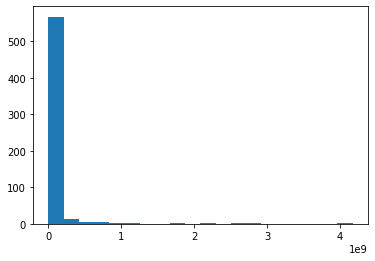

In [22]:
import matplotlib.pyplot as plt
plt.hist(filtered_peaks['pooled_intensity'], bins=20)
#plt.xlim(1e4, 2e9)
print(np.min(filtered_peaks['pooled_intensity']))

In [48]:
len(ppms)

635

(array([292., 165.,  59.,  30.,  17.,  12.,  10.,   2.,   6.,   1.,   2.,
          2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([1.55909458e-03, 1.47759763e-01, 2.93960431e-01, 4.40161099e-01,
        5.86361767e-01, 7.32562435e-01, 8.78763103e-01, 1.02496377e+00,
        1.17116444e+00, 1.31736511e+00, 1.46356578e+00, 1.60976644e+00,
        1.75596711e+00, 1.90216778e+00, 2.04836845e+00, 2.19456912e+00,
        2.34076978e+00, 2.48697045e+00, 2.63317112e+00, 2.77937179e+00,
        2.92557246e+00]),
 <a list of 20 Patch objects>)

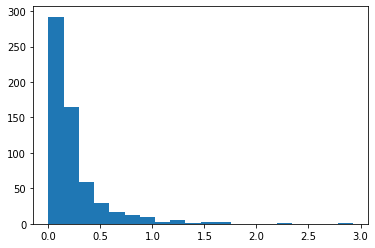

In [24]:
plt.hist(filtered_peaks['pooled_matched_peak_ppm'], bins = 20)

In [10]:
def get_ppm(mz, fmz):
    tolerance = np.abs(fmz - mz)
    ppm = tolerance*1e6/mz
    return ppm

In [8]:
for _, row in frag_picked_peaks.iterrows():
    fmz = row['row m/z']
    frt = row['row retention time']
    fint = row['FRAG_POS.mzXML Peak area']

row ID
row m/z
row retention time
FRAG_POS.mzXML Peak area
Unnamed: 4


In [ ]:
ppm_mz = 3
ppm_rt = 3.0
count_rt = 0
count_spec = 0
max_int_peaks = []
specs_names = []
for mz in filtered_peaks:
    
    filtered_peaks_rt =  filtered_peaks[mz][1]
    filtered_peaks_spec = filtered_peaks[mz][6]
    ppm = get_tolerance(mz, ppm_mz)
    try:
       
        for _, row in frag_picked_peaks.iterrows():
    fmz = row['row m/z']
    frt = row['row retention time']
    fint = row['FRAG_POS.mzXML Peak area']
    except AttributeError:
        print("no peak found",mz)
    
    if filtered_peaks_spec != None:
        count_spec +=1
        for spec in filtered_peaks_spec.keys():
            specs_names.append(spec)

In [18]:
len(max_int_peaks)

601

In [45]:
ints = [i[2] for i in max_int_peaks]
rts = [i[1] for i in max_int_peaks]
mzs = [i[0] for i in max_int_peaks]


In [44]:
print("Lowest intensity: {} \nHighest intensity: {}".format(np.min(ints), np.max(ints)))

Lowest intensity: 2145.0684058222005 
Highest intensity: 338174176.0


Text(0, 0.5, 'Intensity')

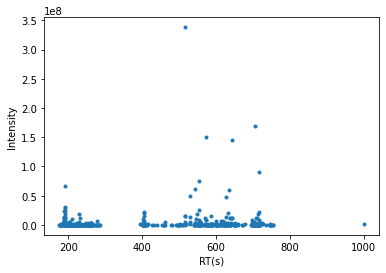

In [48]:
plt.plot(rts, ints, ".")
plt.xlabel("RT(s)")
plt.ylabel("Intensity")

(array([549.,  26.,   9.,   7.,   2.,   0.,   0.,   2.,   1.,   2.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.14506841e+03, 6.76558569e+06, 1.35290263e+07, 2.02924669e+07,
        2.70559075e+07, 3.38193482e+07, 4.05827888e+07, 4.73462294e+07,
        5.41096700e+07, 6.08731106e+07, 6.76365513e+07, 7.43999919e+07,
        8.11634325e+07, 8.79268731e+07, 9.46903137e+07, 1.01453754e+08,
        1.08217195e+08, 1.14980636e+08, 1.21744076e+08, 1.28507517e+08,
        1.35270957e+08, 1.42034398e+08, 1.48797839e+08, 1.55561279e+08,
        1.62324720e+08, 1.69088161e+08, 1.75851601e+08, 1.82615042e+08,
        1.89378482e+08, 1.96141923e+08, 2.02905364e+08, 2.09668804e+08,
        2.16432245e+08, 2.23195685e+08, 2.29959126e+08, 2.36722567e+08,
        2.

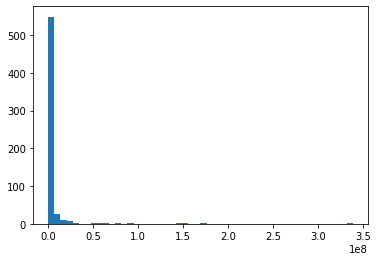

In [63]:
plt.hist(ints, bins = 50)


In [20]:
print("Number of peaks with spectra already attached to them: {}".format(count_spec))

Number of peaks with spectra already attached to them: 215


Text(0.5, 0, 'Datasets')

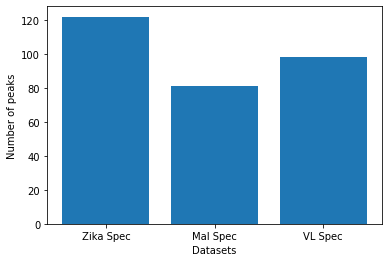

In [30]:
plt.bar(("Zika Spec", "Mal Spec", "VL Spec"), 
        (specs_names.count('gnps2'), specs_names.count('frag_pos_mal'), specs_names.count('frag_pos_vl')))
plt.ylabel("Number of peaks")
plt.xlabel("Datasets")




In [ ]:
from gpr_utils import get_drift_gpr_model
from gpr_utils import try_gp_regressions

In [ ]:
drift_model, accuracy, mae, mse = get_drift_gpr_model(old_mzml_rts, new_mzml_rts, 0.7, True)
#print(drift_model)

In [ ]:
zscore_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

In [ ]:
accuracy_list = []
mae_list = []
for zscore in zscore_list:
    drift_model, accuracy, mae, mse = get_drift_gpr_model(old_mzml_rts, new_mzml_rts, zscore)
    accuracy_list.append(accuracy)
    mae_list.append(mae)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(zscore_list, accuracy_list)

In [ ]:
plt.plot(zscore_list, mae_list)